# Введение в искусственные нейронные сети
# Урок 7. Детектирование объектов

## Содержание методического пособия:


<ol>
<li>Что такое детектирование объектов на изображении</li>
<li>Виды архитектур для детектирования объектов на изображении</li>
<li>Практический пример сегментации</li>
</ol>

## Что такое детектирование объектов на изображении.

детектирование объектов на изображениях, пожалуй одна из самых сложных и самых полезных задач, которую может решать компьютерное зрение. 

<img src='https://drive.google.com/uc?export=view&id=14lTv3rt5CCdTamrpgEau21HFdztKvEaR'>

Сложность проистекает из того факта, что нам нужно не только опредилить какому классу пренадлежат объекты на изображении, отделить одни экзепляры классов от других, но и найти их месторасположение на изображении.

Полезность решения данного задачи связана с тем фактом, что она приближена к возможностям человеческого зрения и восприятия. Мы смотрим на окружающий мир, видем те или иные объекты и понимаем, где они находятся. А понимая, где они находятся мы можем понимать, как они движутся. Нейронные сети решающие подобные задачи могут применяться в самом широком спектре областей - начиная от систем видеонаблюдения до полностью автоматизированных магазинов наподобие Amazon Go.

<table>
<tr>
<td>
<img src='https://drive.google.com/uc?export=view&id=1PqO07j10VvJzg2TXpELU56KI1Ygp_bTm'>
</td>

<td>
<img src='https://drive.google.com/uc?export=view&id=1MifpSYaLffYwVFwpo_2NdW-VQnRmRLfD'>
</td>

</tr>
</table>

В силу того, что решение данной задачи существенно отличается от задачи классификации изображений, существенно отличаются и архитектуры нейронных сетей для этой задачи, которые мы разберем на данном уроке. В первую очередь мы укажем на отличия в датасетах и метриках. 

Для обучения подобных нейронных сетей нам нужно не только понимать какие классы присутсвуют на изображении, но и понимать где они находятся, поэтому в датасетах для object detection, выделяются также bounding box'ы для того, чтобы нейросеть могла корректировать свои предсказания месторасположения объектов по ходу обучения.

Известными датасетами для object detection являются следующие:
1. [The PASCAL VOC'12](http://host.robots.ox.ac.uk/pascal/VOC/)
    - 20 классов
    - Train + Val содержат вместе 11,530 картинок с 27,450 ROI-боксов и 6,929 сегментаøий
    - Картинки бывают разных размеров и качества
    - Статья: [http://host.robots.ox.ac.uk/pascal/VOC/pubs/ever](http://host.robots.ox.ac.uk/pascal/VOC/pubs/everingham15.pdf)
    - Картинки изначально были взяты с сайта [https://www.flickr.com/](https://www.flickr.com/)
2. [MS COCO dataset'17](https://cocodataset.org/)
    - MicroSoft Common Objects in COntext
    - 80 классов
    - Train: 118K (18GB) картинок
    - Val: 5K (1GB) картинок
    - Test: 41K (6GB) картинок
    - Картинки бывают разных размеров и качества
    - Статья: [https://arxiv.org/pdf/1405.0312.pdf](https://arxiv.org/pdf/1405.0312.pdf)
3. [ImageNet](http://image-net.org/download-bboxes)
    - 200 классов
    - В Train + Val вместе 400,000 картинок, взятых из ImageNet, 350,000 bounding box’ов размечено
    - Картинки бывают разных размеров и качества
    - Статьи: [http://image-net.org/about-publication](http://image-net.org/about-publication)
    - Загрузить object detection-часть датасета: [http://image-net.org/download-bboxes](http://image-net.org/download-bboxes)
    - Редко используют в сравнении в статьях
4. [Google Open Images v4'18](https://storage.googleapis.com/openimages/web/index.html)
    - 600 классов
    - Train: 1743K картинок
    - Val: 41K картинок
    - Test: 125K картинок
    - Подробное описание датасета: [https://storage.googleapis.com/openimages/web/factsfigures.html](https://storage.googleapis.com/openimages/web/factsfigures.html)
    - Kaggle-соревнование: [https://www.kaggle.com/c/google-ai-open-images-object-detection-track](https://www.kaggle.com/c/google-ai-open-images-object-detection-track)



<img src='https://drive.google.com/uc?export=view&id=1qFR_GFizsQEFyaxa90CfxioC2BT_FBSH' width=300>

Разметка может быть в разных форматах:

- pascal_voc: min/max [x_min, y_min, x_max, y_max]
- coco: width/height [x_min, y_min, width, height]

Также стоит отметить, что если в случае с задачей классификации, нам было возможно оценить работу нейронной сети, просто определив верный или неверный класс был предсказан, то в случае с object detection нам нужно определить помимо классов, насколько точно определено его местоположение на изображении.

## Метрики для задач детекции

### **Intersection over Union (IoU)**


IoU - это мера величины перекрытия между двумя прямоугольниками. Он вычисляет размер перекрытия между двумя объектами, деленный на общую площадь двух объединенных объектов.

Его можно представить следующим образом:

<img src='https://miro.medium.com/max/700/1*FrmKLxCtkokDC3Yr1wc70w.png'>

In [ ]:
def calculate_iou(gt, pr) -> float:
    """ pascal VOC format [xmin, ymin, xmax, ymax] """

    # Calculate overlap area
    dx = min(gt[2], pr[2]) - max(gt[0], pr[0])
    
    if dx < 0:
        return 0.0
    
    dy = min(gt[3], pr[3]) - max(gt[1], pr[1])

    if dy < 0:
        return 0.0

    overlap_area = dx * dy

    # Calculate union area
    union_area = (
            (gt[2] - gt[0]) * (gt[3] - gt[1]) +
            (pr[2] - pr[0]) * (pr[3] - pr[1]) -
            overlap_area
    )

    return overlap_area / union_area

In [ ]:
from scipy import misc
import cv2
import matplotlib.pyplot as plt

IoU 0.6666666666666666


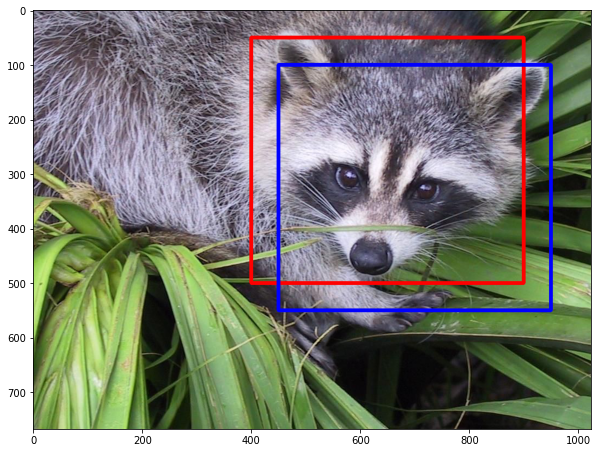

In [ ]:
img = misc.face()

# pascal voc format [xmin, ymin, xmax, ymax]
gt = [400, 50, 900, 500]

start_point, end_point = (gt[0], gt[1]), (gt[2], gt[3])
thickness = 5
  
image = cv2.rectangle(img, start_point, end_point,
                      color=(255, 0, 0), thickness=thickness)
  

# prediction
pred = [450, 100, 950, 550]

start_point, end_point = (pred[0], pred[1]), (pred[2], pred[3])  

image_pred = cv2.rectangle(image, start_point, end_point,
                           color=(0, 0, 255), thickness=thickness)


plt.figure(figsize=(10, 8))
plt.imshow(image_pred)

print(f'IoU {calculate_iou(gt, pred)}')

IoU 0.3380281690140845


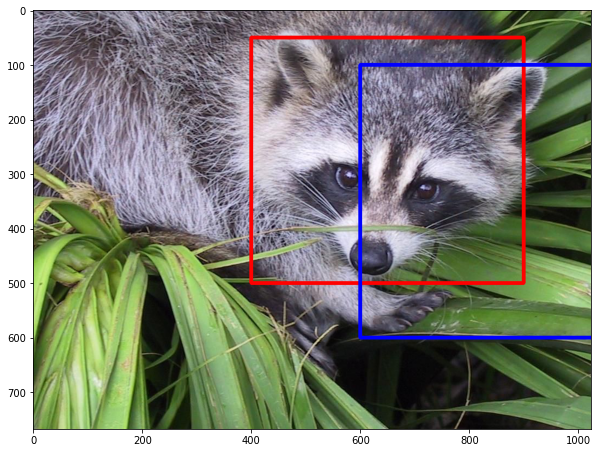

In [ ]:
img = misc.face()

# pascal voc format [xmin, ymin, xmax, ymax]
gt = [400, 50, 900, 500]

start_point, end_point = (gt[0], gt[1]), (gt[2], gt[3])
thickness = 5
  
image = cv2.rectangle(img, start_point, end_point,
                      color=(255, 0, 0), thickness=thickness)
  

# prediction
pred = [600, 100, 1100, 600]

start_point, end_point = (pred[0], pred[1]), (pred[2], pred[3])  

image_pred = cv2.rectangle(image, start_point, end_point,
                           color=(0, 0, 255), thickness=thickness)


plt.figure(figsize=(10, 8))
plt.imshow(image_pred)

print(f'IoU {calculate_iou(gt, pred)}')

IoU 0.3071253071253071


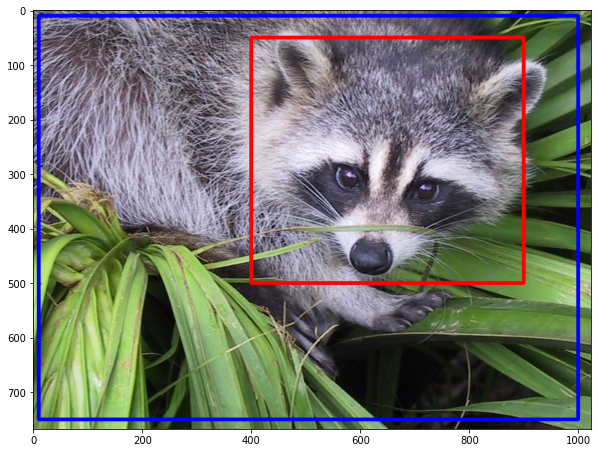

In [ ]:
img = misc.face()

# pascal voc format [xmin, ymin, xmax, ymax]
gt = [400, 50, 900, 500]

start_point, end_point = (gt[0], gt[1]), (gt[2], gt[3])
thickness = 5
  
image = cv2.rectangle(img, start_point, end_point,
                      color=(255, 0, 0), thickness=thickness)
  

# prediction
pred = [10, 10, 1000, 750]

start_point, end_point = (pred[0], pred[1]), (pred[2], pred[3])  

image_pred = cv2.rectangle(image, start_point, end_point,
                           color=(0, 0, 255), thickness=thickness)


plt.figure(figsize=(10, 8))
plt.imshow(image_pred)

print(f'IoU {calculate_iou(gt, pred)}')

### **mAP (mean Average Precision)**

Более подробно можете почитать [здесь](https://jonathan-hui.medium.com/map-mean-average-precision-for-object-detection-45c121a31173).

**mean Average Precision (mAP)** - среднее значение максимумов precision'ов при различных значениях recall'ов.

При каждом пороговом значении t вычисляется значение точности, основанное на количестве истинных положительных результатов (TP), ложных отрицательных результатов (FN) и ложных положительных результатов (FP), полученных в результате сравнения предсказанного объекта со всеми основными объектами истинности:


**True Positive** подсчитывается, когда предсказанный bounding box совпадает с истинным bounding box с IoU выше трешхолда.

**False Positive** указывает на то, что предсказанный bounding box не имел связанного с ним объекта ground truth.

**False Negative** указывает на то, что объект ground truth не имеет связанного предсказанного bounding box.

<img src='https://drive.google.com/uc?export=view&id=1rMpJT4tlWCzLpT2B_xf5a1HCqsYHFx5d'>

$$Precision = \frac{TP}{TP + FP}$$
$$Recall = \frac{TP}{TP + FN}$$

Средняя точность одного изображения вычисляется как среднее значение приведенных выше значений точности при каждом пороге IoU:

$$ AP = \frac{1}{11} (AP_r(0)+AP_r(0.1)+...+AP_r(1)) = \frac{1}{11}(5 * 1 + 4 * 0.57 + 2 * 0.5)$$

<img src='https://drive.google.com/uc?export=view&id=1_3_gvhGivTP-V1o8-WGcS7JRgQDt5W23'>

mAP - среднее AP по всем классам.


Здесь представлены работа двух теоретических детекторов на двух картинках и их mAP будут одинковыми, хотя очевидно, что второй детектор выдает ненужные bounding box'ы для каждого объекта, что показатель не самой лучшей детекции.
 
<img src='https://drive.google.com/uc?export=view&id=1MIIVJN1Tov-itBIPB-mLkdZrlBZ7BHhK'>

# Виды архитектур для детектирования объектов на изображении.


[Репозиторий со списком детекторов](https://github.com/hoya012/deep_learning_object_detection).

<img src='https://drive.google.com/uc?exportr=view&id=1S_vzpElPE0zzu7Q3VFiDlxyWcMeB8Vk-'>

Начиная с 2012 г., когда широкие круги специалистов в области компьютерного зрения стали использовать нейронные сети, для тех задач, которые прежде решали классические алгоритмы комп зрения, появилось и продолжает появляться множество архитектур предназначенных для object detection. Мы осветим несколько архитектур, которые стали важными вехами с одной стороны, а с другой стороны их модификации являются на данный момент лучшими способами для решения задачи object detection.

__________________

Чтобы найти, где находится объект на картинке, мы можем пройтись скользящим окном и каждый раз новую область картинки подавать на классификационную сеть.

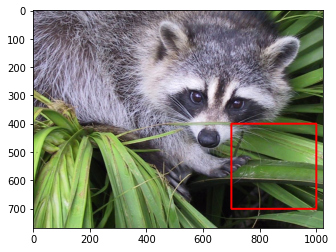

In [ ]:
import time
from IPython.display import clear_output


img = misc.face()
image = img.copy()

window_amounts = 2
window = 600
step = 100
thickness = 5


for i in range(window_amounts):
    for y in range(img.shape[0] // step):
        for x in range(img.shape[1] // step):
            image = img.copy()

            start_point = (x * step, y * step)
            end_point = (x * step + window, y * step + window)
            if end_point[0] > img.shape[1] or end_point[1] > img.shape[0]:
                break

            image = cv2.rectangle(image, start_point, end_point,
                                  color=(255, 0, 0), thickness=thickness)
            
            plt.imshow(image)
            plt.show()
            time.sleep(0.5)
            clear_output(wait=True)
    window = window // 2

Существует ряд проблем с этим подходом:

- Проверка каждой области в изображении на существование в ней объекта - это очень медленно
- Подход чувствителен к выбору параметров. Различные значения масштаба области изображения и размера скользящего окна могут привести к кардинально различным результатам.

Любой детектор должен генерировать на выход 6 параметров:
<ul>
<li>x_min, x_max, y_min, y_max</li>
<li>класс</li>
<li>вероятность</li>
</ul>

Здесь получается сразу же и задача классификации, и задача регрессии и нельзя сразу всё начать решать одновременно. Сначала можем получить координаты, а потом только получить класс - это так называемые Two-Stage Detectors (двустадийные детекторы).

## R-CNN

<img src='https://drive.google.com/uc?export=view&id=1xLEUoJNXrAbBIQOp0rbmPuchXkRXLj8N'>

R-CNN (Region Convolution Neural Network) - это одна из первых архитектур для решения задачи object detection на основе сверточных нейронных сетей.
Данная архитектура состоит из трех частей:

1. Классический алгоритм компьютерного зрения, который находит области изображения, на которых потенциально могут содержаться объекты

2. Сверточная нейронная сеть, которая запускается по-отдельности в каждом найденном регионе и выдает набор фичей.

3. SVM алгоритм, который обучается на этих фичах определять те или иные классы.


На первом шаге изображение разбивается на маленькие гипотезы разных размеров (регионы). Авторы R-CNN используют Selective Search. Таким образом выделяется примерно 2000 разных регионов, которые частично друг друга перекрывают.

### Selective Search

Более подробно про алгоритм [здесь](https://www.pyimagesearch.com/2020/06/29/opencv-selective-search-for-object-detection/).
Он позволяет составить набор гипотез (класс объекта пока не имеет значения) и на основе сегментации определить границы объектов по интенсивности пикселей, перепаду цветов, контраста и текстур.

<img src='https://drive.google.com/uc?export=view&id=1jEcaiKYO68N6a6QiwX44FNmvMCgAcm8G' width=600>

In [ ]:
!wget 'https://drive.google.com/uc?export=dowloading&id=1NyTl7DcoI_S9zQGxOqfYfvtcka0h924g' -O test_image.jpg
!wget 'https://drive.google.com/uc?export=download&id=1tEZeoY00ZuoQc02mLqY-_DiUmAKELdlu' -O test_image_1.jpg

--2022-02-25 16:50:44--  https://drive.google.com/uc?export=dowloading&id=1NyTl7DcoI_S9zQGxOqfYfvtcka0h924g
Resolving drive.google.com (drive.google.com)... 142.250.152.101, 142.250.152.113, 142.250.152.100, ...
Connecting to drive.google.com (drive.google.com)|142.250.152.101|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-08-c0-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/im3fo753s7j2e15fjlpo4elslllff09s/1645807800000/14904333240138417226/*/1NyTl7DcoI_S9zQGxOqfYfvtcka0h924g?e=dowloading [following]
--2022-02-25 16:50:45--  https://doc-08-c0-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/im3fo753s7j2e15fjlpo4elslllff09s/1645807800000/14904333240138417226/*/1NyTl7DcoI_S9zQGxOqfYfvtcka0h924g?e=dowloading
Resolving doc-08-c0-docs.googleusercontent.com (doc-08-c0-docs.googleusercontent.com)... 142.251.6.132, 2607:f8b0:4001:c5a::84
Connecting to doc-08-c0-docs.googleusercontent.com (doc-0

(376, 1241, 3)


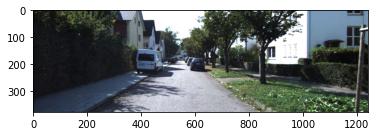

In [ ]:
img = cv2.imread('/content/test_image_1.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
print(img.shape)
plt.imshow(img)
plt.show()

In [ ]:
%%time
# Объект Selective Search Segmentation
sss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()

# запускаем с картинкой
sss.setBaseImage(img)
  
# Выбираем точный метод 
sss.switchToSelectiveSearchQuality()

# Делаем selective search segmentation 
rects = sss.process() 
# вернёт массив прямоугольников, где возможно что-то есть
print(rects.shape)

(12880, 4)
CPU times: user 27.3 s, sys: 479 ms, total: 27.8 s
Wall time: 23.7 s


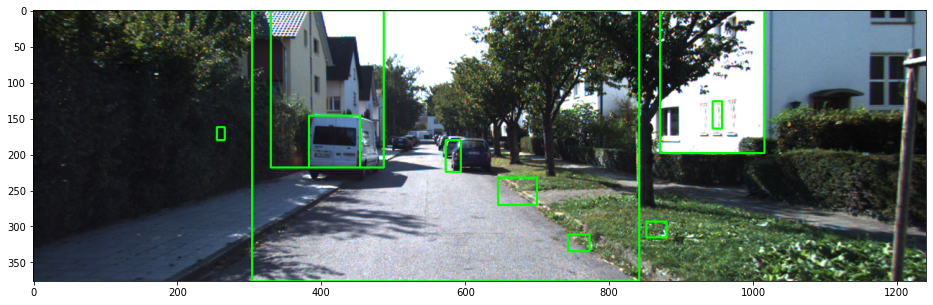

In [ ]:
# Построим области

num_Rects = 10  # число выводимых region proposals (прямоугольников)

#создаем копию исходной картинки
img_ = img.copy()

for i, rect in enumerate(rects): 
    if (i < num_Rects):
        # x, y - координаты левого верхнего угла; w, h - ширина и высота области
        x, y, w, h = rect
        # рисуем рамку      
        cv2.rectangle(img_, (x, y), (x+w, y+h), (0, 255, 0), 2) 
    else: 
        break 

plt.figure(figsize=(16, 5))
plt.imshow(img_) 
plt.show()

## Fast R-CNN

R-CNN работала медленно. Это происходило из-за того, что приходилось многократно запускать сверточную часть на множестве областей изображения. На одно изображение уходили десятки секунд. Также данная архитектура не могла обучаться целиком, а обучалась по-отдельности. Кроме того обучалась данная нейросеть тоже медленно. 


<img src='https://drive.google.com/uc?export=view&id=1BVfWnSccmcrX6g6HjOA5gWATXDZTcASs'>

Данная архитектура появилась в 2015 г. и была призвана решить упомянутые выше проблемы R-CNN. Fast R-CNN состоял уже из следующих компонентов:

1. Сверточная нейронная сеть которая запускается один раз на всем изображении.

2. ROI - компонент, который позволяет искать области, где могут находиться объекты не на первоначальных пикслелях изображения, а на карте признаков, которую выдает сверточная часть данной архитектуры.

3. Полносвязный слой, который делает непосредственно предсказание.



Данная архитектура ускорила и обучение и скорость работы изначальной архитектуры R-CNN существенно. Теперь одно изображение обрабатывалось нейронной сетью за 2 секунды. Однако это по-прежнему было далеко от real-time.

## Faster R-CNN

<img src='https://drive.google.com/uc?export=view&id=1F4SgQxscVL3S8Vva_R8VEh2cTfqCQlv-'>

Данная архитектура появилась в 2016 году и является как одной из самых точных на сегодняшний день, так и относительно быстрой, время обработки ею изображения занимает меньше секунды.

Усовершенствование произошло из-за переработки генерации регионов, потому что этот процесс всё еще занимал приличное время, он был основан не на нейросетевых подходах, а вот в Faster R-CNN данный этап перешел на нейронную сеть, которая обучается находить правильные регионы.

Она состоит из следующих компонентов:
1. Сверточная нейронная сеть
2. Нейронная сеть, корректирующая работу ROI, выбирающего регионы в карте признаков, получающейся в ходе работы сверточной части.
3. Полносвязные слои осуществляющие предсказание.

Данная архитектура позволяла окончательно позволили обучать нейронную сеть для object detection end-to-end, т.е. нейронная сеть училась и определять классы объектов и корректировать предсказания местоположения объектов -(bounding box'ы).

## YOLO (You Only Look Once)

[Подробный разбор сети](https://blog.paperspace.com/how-to-implement-a-yolo-object-detector-in-pytorch/).

Несмотря на то, что Faster R-CNN работала относительно быстро и с высокой точностью, она все-таки была тяжеловесна и недостаточно быстра для многих задач. Все вышеприведенные архитектуры относиться к двухстадийным архитектурам, т.е. мы отдельно находим объекты и отдельно их классифицируем.

Архитектура YOLO, появившаяся в 2016 г. является первой популярной одностадийной архитектурой. 





Рассмотрим, в чем смысл одностадийной архитектуры.

Посмотрим, что находится на выходе backbone сети - это тензор $width * height * channels$. Вектор, который имеет размерность $1 * 1 * channels$ описывает некоторую область исходного изображения и то, что происходит вокруг этой группы пикселей.

Из этого вектора мы хотим получить 5 значений:
1. есть ли в этой ячейке объект 
2. смещение по x
3. смещение по y
4. ширина объекта
5. высота объекта


<img src='https://drive.google.com/uc?export=view&id=1Gcnz5r9Iff3iCW85jU52Ct02FOp-nDnf'>



Смещения изменяются от 0 до 1 - это величина, показывающая, где именно в группе пикселей находится центр объекта. <img src='https://drive.google.com/uc?export=view&id=1dWcnUUPmXjMycKfcFPusaWLJtlcwP9Sm'>



Тут проблема в линейном слое - из него столько информации очень сложно получить, поэтому можем заменить этот слой на сверточный. На выходе будем получать 5 каналов (наши 5 выходов: вероятность появления объекта, смещения по x, y, ширина и высота объекта).

C архитектурой выше мы никак не решаем задачу классификации, но можем добавить C каналов, и поверх них будем ставить Softmax для классификации.

<img src='https://drive.google.com/uc?export=view&id=1vFhT8u1Vnb2L79kqu9-m9GQ4qljeNlel'>


То, что обсудили выше - это и есть архитектура YOLO. Но тут есть проблема. В одной группе пикселей может быть несколько объектов, но с такой архитектурой мы не сможем детектировать более, чем один объект. На помощь нам приходят якоря.

Добавим детектор маленьких объектов, средних объектов и больших, получаем уже 3 объекта, которые можем находить в ячейках, если якорей сделаем больше, то соответственно будет больше возможных объектов в ячейках. И всё это можно сделать с помощью одной свертки. Если на один объект была свертка, переводящая 512 каналов в (5 + С), то на три объекта это свертка будет переводить из 512 каналов в (5 + С) * 3.

Разные размеры объектов (маленькие, средние, большие) называются якорями (Anchor). Их можно выбирать не только по размерам, но и по пропорциям: маленький объект вытянутый по горизонтали, маленький объект вытянутый по вертикали и так далее для всех остальных размеров и уже имеем 9 разных якорей.

<img src='https://drive.google.com/uc?export=view&id=1Katco7s1yJqs8PQfINl93wNnN5buIy79'>

YOLO разбивает все изображение на фиксированное количество квадратов. Затем за один проход она пытается предсказать в разных комбинациях этих квадратов те или иные классы. Таким образом данная нейронная сеть несколько теряет в точности, но существенно приобретает в скорости работы.

<img src='https://drive.google.com/uc?export=view&id=1RS1_J6E9y4ZKlJDNv7Y0FaOuJyptfbY8'>

Вначале получим признаки с помощью backbone сети, а далее будем смотреть на feature map'ы, опираясь на заранее построенные области - Anchor (якорные) при этом ещё и в разных масштабах. На выходе имеем очень много bounding box'ов.

<img src='https://drive.google.com/uc?export=view&id=1QGVGCzQpC0AcR_pGL_RxKD90z4iyT4Im'>

### **Non-maximum Suppression (NMS)**


[Более подробно](https://towardsdatascience.com/non-maximum-suppression-nms-93ce178e177c).

Наша нейронная сеть из-за большого количества якорей в одном суперпикселе будет генерить много bounding box'ов наших объектов, теперь нужно их отфильтровать. Это можно сделать с помощью подхода Non-maximum suppression.

<img src='https://drive.google.com/uc?export=view&id=1AU4_4sc1jIkwUVICPu-uMorhKPfXNrAC' width=500>


Если у двух bounding box'ов IoU больше заданного трешхолда, то мы считаем, что эти два bounding box'а совпадают, дальше нужно задать трешхолд по вероятности, если вероятность первого bb меньше порога, то избавляемся от него или же от второго bb, если его вероятность меньше порога.
Если вероятность у двух bb хорошие, то будем объединять их, путем растягивания bounding box'a, который будет охватывать обе границы.


<img src='https://drive.google.com/uc?export=view&id=1yEsQJKQtUSxwdw-yE2KxCQTbManIuxQp' width=600>

## SSD (Single Shot MultiBox Detector)

Данная архитектура появилась в 2016 г. и различные ее модификации являются одними из самыми применяемых на практике.

Проблема YOLO, что мы предсказываем объекты только на основании последней карты активации, но ведь можно предсказывать более мелкие объекты из ранних карт активаций.

<img src='https://drive.google.com/uc?export=view&id=1cCXfk2llmGl3N9Qj5g6UmtEYZ_FuxYyG'>


Она также как и YOLO является одностадийным дектором, также как и YOLO пытается на лету определить boundig box'ы и классы, но считывание ее результатов происходит на разных масштабах в конце нейронной сети, подобному так как это происходит в архитектуре FPN.

<img src='https://drive.google.com/uc?export=view&id=1aOcNRwRBt5ghcuGuh1K0HaEQzgS351hN'>

## Retina Net

Проблемы SSD:
- мелкие объекты получаются из ранних активационных карт
- но в ранних активационных картах совсем нет информации о контексте

Чтобы учитывать контекст для детекции можем объединить идеи SSD и сегментациия со skip connections.

Дальние карты активаций учитывают контекст и большие объекты, а ближние слои учитывают мальнькие объекты, нам нужно соединить мелкие признаки с контекстом с помощью конкатенаций.

И еще разработчики обучали эту сеть на новом Focal Loss'е, про него более подробно можно почитать в [оригинальной статье](https://arxiv.org/pdf/1708.02002.pdf).

<img src='https://drive.google.com/uc?export=view&id=1ielb4_cGycvsL_YgsnwzFoxFeMn0vexh' width=600>

# Практический пример 

Запишем основные функции из [примера](https://github.com/tensorflow/hub/blob/master/examples/colab/object_detection.ipynb) TensorFlow и адаптируем их для своих целей

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub

import matplotlib.pyplot as plt
import time

import numpy as np
from PIL import ImageColor, ImageDraw, Image, ImageFont, ImageOps

In [ ]:
# выводит картинку
def display_image(image):
    fig = plt.figure(figsize=(20, 15))
    plt.grid(False)
    plt.imshow(image)

# Рисуем рамку на изображении
def draw_bounding_box_on_image(image, 
                               ymin, xmin, ymax, xmax,
                               color, font, thickness=4, display_str_list=()):
        
    """Adds a bounding box to an image."""

    draw = ImageDraw.Draw(image)
    im_width, im_height = image.size
    (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                                    ymin * im_height, ymax * im_height)
    draw.line([(left, top),
                (left, bottom),
                (right, bottom),
                (right, top),
                (left, top)],
                width=thickness,
                fill=color)

    # If the total height of the display strings added to the top of the bounding
    # box exceeds the top of the image, stack the strings below the bounding box
    # instead of above.
    display_str_heights = [font.getsize(ds)[1] for ds in display_str_list]
    # Each display_str has a top and bottom margin of 0.05x.
    total_display_str_height = (1 + 2 * 0.05) * sum(display_str_heights)

    if top > total_display_str_height:
        text_bottom = top
    else:
        text_bottom = bottom + total_display_str_height

    # Reverse list and print from bottom to top.
    for display_str in display_str_list[::-1]:
        text_width, text_height = font.getsize(display_str)
        margin = np.ceil(0.05 * text_height)
        draw.rectangle([(left, text_bottom - text_height - 2 * margin),
                        (left + text_width, text_bottom)],
                    fill=color)
        draw.text((left + margin, text_bottom - text_height - margin),
                display_str,
                fill="black",
                font=font)
        text_bottom -= text_height - 2 * margin

# Рисуем все рамки
# max_boxes - максимальное число объектов для отображения
# min_score = 0.01 - минимальная точность их детекции
# можно менять

def draw_boxes(image, boxes, class_names, scores, max_boxes=3, min_score=0.01):
    """Overlay labeled boxes on an image with formatted scores and label names."""
    colors = list(ImageColor.colormap.values())
    font = ImageFont.load_default()

    for i in range(min(boxes.shape[0], max_boxes)):
        if scores[i] >= min_score:
            ymin, xmin, ymax, xmax = tuple(boxes[i])
            display_str = "{}: {}%".format(class_names[i].decode("ascii"),
                                            int(100 * scores[i]))
            color = colors[hash(class_names[i]) % len(colors)]
            image_pil = Image.fromarray(np.uint8(image)).convert("RGB")
            draw_bounding_box_on_image(image_pil,
                                    ymin, xmin, ymax, xmax,
                                    color, font, display_str_list=[display_str])
            np.copyto(image, np.array(image_pil))
    
    return image

In [ ]:
def load_img(path):
  # path - маршрут и имя файла для обработки
  img = tf.io.read_file(path)
  img = tf.image.decode_jpeg(img, channels=3)
  # вернет картинку как тензор
  return img

In [ ]:
# Найдем рамку
# max_boxes - максимальное число объектов для отображения
# min_score - минимальная точность их детекции
# можно менять

def get_bounding_box_on_image(image, boxes, class_names, scores, max_boxes=100, min_score=0.1):
    """
    Overlay labeled boxes on an image with formatted scores and label names.
    """
    if len(image.shape)>3:
        image=image.reshape(image.shape[-3],image.shape[-2],image.shape[-1])

    I_shape = np.uint8(image).shape

    im_array = []
    for i in range(min(boxes.shape[0], max_boxes)): 
        if scores[i] >= min_score:
            ymin, xmin, ymax, xmax = tuple(boxes[i])

            yminI = np.int(ymin*I_shape[0])
            ymaxI = np.int(ymax*I_shape[0])
            xminI = np.int(xmin*I_shape[1])
            xmaxI = np.int(xmax*I_shape[1])
            imf = np.array(image)[yminI:ymaxI,xminI:xmaxI,:]
            im_array.append(imf.copy())  
        
    return im_array

Загрузка детектора

In [ ]:
module_handle = "https://tfhub.dev/google/openimages_v4/ssd/mobilenet_v2/1" #@param ["https://tfhub.dev/google/openimages_v4/ssd/mobilenet_v2/1", "https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1"]

detector = hub.load(module_handle).signatures['default']

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [ ]:
def run_detector(detector, path, max_boxes=10):
    '''
    1) вызывает детектор с картинкой
    2) выводит результат на картинке

    detector - объект детектор, 
    path - маршрут и имя файла для обработки
    '''
    img = load_img(path)

    converted_img  = tf.image.convert_image_dtype(img, tf.float32)
    start_time = time.time()
    result = detector(converted_img[None])
    end_time = time.time()
    print(f'Took {end_time - start_time:.4f} seconds')

    result = {key: value.numpy() for key, value in result.items()} 

    image_with_boxes = draw_boxes(img.numpy(),
                                  result["detection_boxes"],
                                  result["detection_class_entities"],
                                  result["detection_scores"],
                                  max_boxes=max_boxes)

    display_image(image_with_boxes)
    return result

Проверяем детектор

In [ ]:
from pathlib import Path


root_path = '/content'
files = [str(i) for i in Path(root_path).glob('*.jpg')]
files

['/content/test_image_1.jpg', '/content/test_image.jpg']

Took 0.8056 seconds


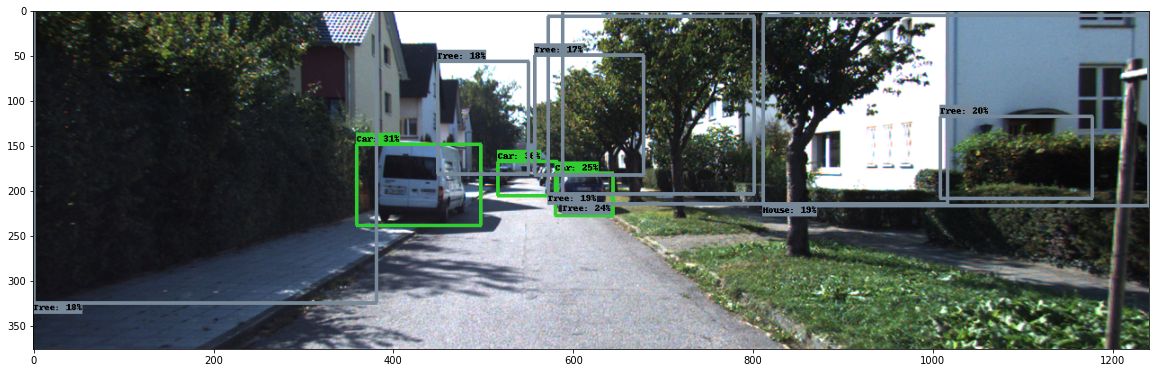

In [ ]:
result = run_detector(detector, files[0], max_boxes=10)

Took 0.6843 seconds


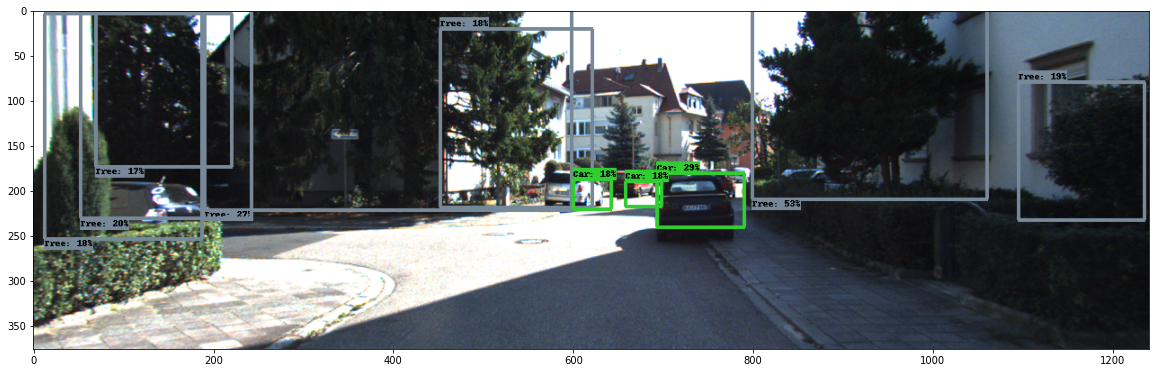

In [ ]:
result = run_detector(detector, files[1])

In [ ]:
result

{'detection_boxes': array([[0.01124095, 0.57246625, 0.7180435 , 0.81061697],
        [0.37062085, 0.29918805, 0.62772465, 0.38850752],
        [0.16528626, 0.37654802, 0.4849454 , 0.43857172],
        [0.01244199, 0.00967406, 0.7848043 , 0.29995763],
        [0.        , 0.93825495, 0.05342829, 0.98050714],
        [0.01606689, 0.4899109 , 0.5863213 , 0.6225845 ],
        [0.07706903, 0.32411277, 0.43151575, 0.3687895 ],
        [0.1740109 , 0.44360328, 0.527733  , 0.5380937 ],
        [0.01691661, 0.51303923, 0.6713185 , 0.75045836],
        [0.        , 0.23254405, 0.47295684, 0.341072  ],
        [0.00259734, 0.81473446, 0.45595756, 0.9954424 ],
        [0.16081521, 0.93637484, 0.36258137, 0.98321575],
        [0.47160545, 0.46675962, 0.600078  , 0.5145467 ],
        [0.56025153, 0.3616225 , 0.62651044, 0.373353  ],
        [0.25623742, 0.4381925 , 0.4749422 , 0.511331  ],
        [0.        , 0.09521312, 0.48527613, 0.36074048],
        [0.37126076, 0.30082726, 0.62432414, 0.389168

https://www.kaggle.com/julichitai/gb-racoon-detection

https://www.kaggle.com/julichitai/gb-dog-and-cat-detection-imageai

## Домашнее задание

1.  Попробуйте обучить нейронную сеть YOLOv3 из ImageAI на любом датасете. Можете взять один из этих наборов данных:
- [https://www.kaggle.com/brendan45774/chess-piece-dectection/](https://www.kaggle.com/brendan45774/chess-piece-dectection/code)
- [https://www.kaggle.com/mbkinaci/fruit-images-for-object-detection](https://www.kaggle.com/mbkinaci/fruit-images-for-object-detection)
- [https://www.kaggle.com/sshikamaru/car-object-detection](https://www.kaggle.com/sshikamaru/car-object-detection)
- [https://www.kaggle.com/lplenka/coco-car-damage-detection-dataset](https://www.kaggle.com/lplenka/coco-car-damage-detection-dataset)
2. *Сделайте краткий обзор какой-нибудь научной работы, посвященной алгоритму для object detection, который не рассматривался на уроке. Проведите анализ: Чем отличается выбранная вами архитектура нейронной сети от других архитектур? В чем плюсы и минусы данной архитектуры? Какие могут возникнуть трудности при применении данной архитектуры на практике?


## Дополнительные материалы


1. [Оригинальная научная статья по MS COCO dataset](https://arxiv.org/pdf/1405.0312.pdf)
2. [Оригинальная научная статья по R-CNN](https://arxiv.org/pdf/1311.2524.pdf)
3. [Оригинальная научная статья по Fast R-CNN](https://arxiv.org/pdf/1504.08083.pdf)
4. [Оригинальная научная статья по Faster R-CNN](https://arxiv.org/pdf/1506.01497.pdf)
5. [Оригинальная научная статья по YOLO](https://arxiv.org/pdf/1506.02640.pdf)
6. [Оригинальная научная статья по SSD](https://arxiv.org/pdf/1512.02325.pdf)
7. [Оригинальная научная статья по RetinaNet](https://arxiv.org/pdf/1708.02002.pdf)
8. [mAP (mean Average Precision) for Object Detection](https://jonathan-hui.medium.com/map-mean-average-precision-for-object-detection-45c121a31173)
9. [Selective Search](https://www.pyimagesearch.com/2020/06/29/opencv-selective-search-for-object-detection/)
10. [Методы одностадийной детекции, Михаил Романов](https://youtu.be/Cm9uDp1sTsg)

## Используемая литература 

Для подготовки данного методического пособия были использованы следующие ресурсы:
<ol>
    <li>https://github.com/ljanyst/ssd-tensorflow</li>
    <li>Recent Advances in Deep Learning for Object Detection. Xiongwei Wu, Doyen Sahoo, Steven C.H. Hoi. 2019</li>    
    <li>Object Detection with Deep Learning: A Review. Zhong-Qiu Zhao, Peng Zheng, Shou-tao Xu, Xindong Wu. 2019
</li>
    <li>Object Detection in 20 Years: A Survey. Zhengxia Zou (1), Zhenwei Shi (2), Yuhong Guo (3 and 4), Jieping Ye (1 and 4) ((1) University of Michigan, (2) Beihang University, (3) Carleton University, (4) DiDi Chuxing). 2019</li>
    <li>Википедия</li>  
</ol>

## Определения

**Intersection over Union (IoU)** — это мера величины перекрытия между двумя прямоугольниками). Он вычисляет размер перекрытия между двумя объектами, деленный на общую площадь двух объединенных объектов.

**mean Average Precision (mAP)** — среднее значение максимумов precision'ов при различных значениях recall'ов.
